In [27]:
from kan.experiments.multkan_hparam_sweep_materials import sweep_multkan, evaluate_params
import numpy as np
import pandas as pd
import torch
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from kan.custom_processing import remove_outliers_iqr
import json
import datetime

file_tuning = "JHC_log_x_HCO3-_20251114_0925"
name_y = "log_x_HCO3-"

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"This script is running on {device}.")

dir_current = os.getcwd()
save_heading = os.path.join(dir_current, "extra_figures", file_tuning + "_analysis")

d_opt = pd.read_excel(
    os.path.join(dir_current, "multkan_sweep_autosave", file_tuning + ".xlsx"), sheet_name='best_avg_by_params',
)

This script is running on cpu.


In [28]:
filepath = os.path.join(dir_current, "Alamo_Data_JHC.csv")

filedata = pd.read_csv(filepath)
name_X = ["CO2_loading", "MEA_mol", "Temp"]
df_in = filedata[name_X]
df_out = filedata[[name_y]]

df_in_final, df_out_final = remove_outliers_iqr(df_in, df_out)

removed_count = len(df_in) - len(df_in_final)  # 몇 개 지웠는지 세기
print(f"이상치 제거 후 데이터 수: {len(df_in_final)} 개 ({removed_count} 개 제거됨)")
print("--- 이상치 제거 완료 ---\n")

X = df_in_final[name_X].values
y = df_out_final[name_y].values.reshape(-1, 1)

X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.2,
                                                  random_state=42)  # 0.2 × 0.8 = 0.16 (전체의 16%)

print(f"전체 데이터셋 크기: {len(X)}")
print(f"훈련셋 크기: {len(X_train)} ({len(X_train) / len(X) * 100:.1f}%)")
print(f"검증셋 크기: {len(X_val)} ({len(X_val) / len(X) * 100:.1f}%)")
print(f"테스트셋 크기: {len(X_test)} ({len(X_test) / len(X) * 100:.1f}%)")

# 1. MinMaxScaler 객체 생성 --- 범위를 0.1~0.9로 재설정
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_train_norm = scaler_X.fit_transform(X_train)  # 훈련 데이터로 스케일러 학습 및 변환 (fit_transform)
y_train_norm = scaler_y.fit_transform(y_train)  # X_train의 각 변수(컬럼)별로 최소값은 0, 최대값은 1이 되도록 변환됩니다.

X_val_norm = scaler_X.transform(X_val)
X_test_norm = scaler_X.transform(X_test)

y_val_norm = scaler_y.transform(y_val)
y_test_norm = scaler_y.transform(y_test)

y = df_out_final[name_y].values.reshape(-1, 1)

이상치 제거 후 데이터 수: 11410 개 (0 개 제거됨)
--- 이상치 제거 완료 ---

전체 데이터셋 크기: 11410
훈련셋 크기: 7302 (64.0%)
검증셋 크기: 1826 (16.0%)
테스트셋 크기: 2282 (20.0%)


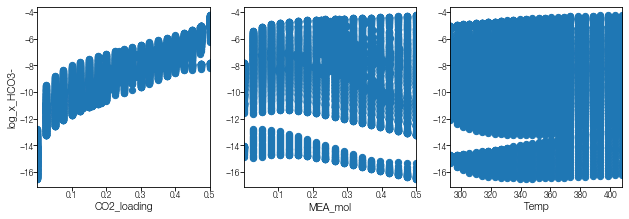

In [29]:
import matplotlib.pyplot as plt

num_input = X.shape[1]
fig, axs = plt.subplots(1, num_input, figsize=(10, 3))
for i in range(num_input):
    ax = axs[i]
    ax.scatter(X[:, i], y)
    ax.set_xlabel(name_X[i])
axs[0].set_ylabel(name_y)
plt.show()


| train_loss: 1.78e-02 | test_loss: 1.78e-02 | reg: 2.14e+00 | : 100%|█| 50/50 [00:45<00:00,  1.11it
| train_loss: 1.70e-02 | test_loss: 1.72e-02 | reg: 2.06e+00 | : 100%|█| 50/50 [00:43<00:00,  1.15it
| train_loss: 1.69e-02 | test_loss: 1.74e-02 | reg: 2.14e+00 | : 100%|█| 50/50 [00:37<00:00,  1.35it
| train_loss: 1.22e-02 | test_loss: 1.26e-02 | reg: 2.07e+00 | : 100%|█| 50/50 [00:39<00:00,  1.26it


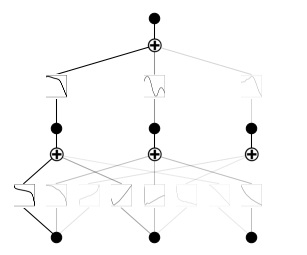

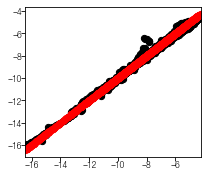

In [30]:
d_opt_flat = d_opt.iloc[0]
d_opt_flat = d_opt_flat.to_dict()
params = {k: v for k, v in d_opt_flat.items() if "param_" in k}
params = {key.replace('param_', ''): value for key, value in params.items()}

res, model, fit_kwargs, dataset = evaluate_params(
    X_train_norm, y_train_norm, X_val_norm, y_val_norm, params, X_test_norm, y_test_norm,
    0, scaler_y, device.type,
    save_heading=save_heading
)

In [31]:
print(res)

TrialResult(params={'lamb': 0.001, 'lamb_coef': 0.1, 'lamb_coefdiff': 0.1, 'lamb_entropy': 0.1, 'lr': 1, 'max_grid': 10, 'prune': True, 'pruning_th': 0.01, 'update_grid': True, 'width': [[3, 0], [12, 0], [1, 0]]}, val_loss=0.10003664344549179, train_loss=0.09801167994737625, test_loss=0.09895607084035873, r2_train=0.9958275472918107, r2_val=0.9953298806961074, r2_test=0.9955388914457535, seed=0, device='cpu', spline_train_loss=0.0204626377671957, spline_test_loss=0.021034622564911842)


In [32]:
from kan.utils import ex_round
model.auto_symbolic(weight_simple=0., a_range=(-100,100), b_range=(-100,100))
model.fit(dataset=dataset, **fit_kwargs)
print(str(ex_round(model.symbolic_formula()[0][0], 4)))

r2 is 0.9876379370689392
fixing (0,0,0) with tan, r2=0.99, c=3
r2 is 0.9958370923995972
fixing (0,0,1) with log, r2=1.0, c=2
r2 is 0.9537478089332581
fixing (0,0,2) with tan, r2=0.95, c=3
r2 is 0.9866946935653687
fixing (0,1,0) with abs, r2=0.99, c=3
Best value at boundary.
r2 is 0.7107487320899963
r2 is not very high, please double check if you are choosing the correct symbolic function.
fixing (0,1,1) with 1/x, r2=0.71, c=2
r2 is 0.9935948848724365
fixing (0,1,2) with tan, r2=0.99, c=3
r2 is 0.9994814991950989
fixing (0,2,0) with cos, r2=1.0, c=2
r2 is 0.9997107982635498
fixing (0,2,1) with tan, r2=1.0, c=3
Best value at boundary.
r2 is 0.0
r2 is not very high, please double check if you are choosing the correct symbolic function.
fixing (0,2,2) with 0
r2 is 0.9956973195075989
fixing (1,0,0) with arctan, r2=1.0, c=4
r2 is 0.9226148724555969
fixing (1,1,0) with abs, r2=0.92, c=3
Best value at boundary.
r2 is 0.017460612580180168
r2 is not very high, please double check if you are choo

| train_loss: 1.95e-02 | test_loss: 1.95e-02 | reg: 1.04e-01 | : 100%|█| 50/50 [00:53<00:00,  1.07s/


-0.0968*(-0.2117*tan(2.3416*x_1 + 2.1118) + 0.5373*tan(1.978*x_2 - 4.435) + 1)**2 + 2.3753*Abs(-0.0542*log(5.516 - 4.8532*x_1) + 0.025*tan(0.7746*x_3 + 8.3654) + 0.1125 - 0.0017/(0.2702 - 9.9985*x_2)) + 0.4279*atan(0.2222*cos(1.7158*x_3 - 8.974) + 1.1753*tan(2.4923*x_1 + 1.9062) + 0.0343*Abs(8.1873*x_2 - 1.6349) + 3.7491) + 0.0825


{'train': 0.9894203436261476, 'test': 0.9893858785805683}


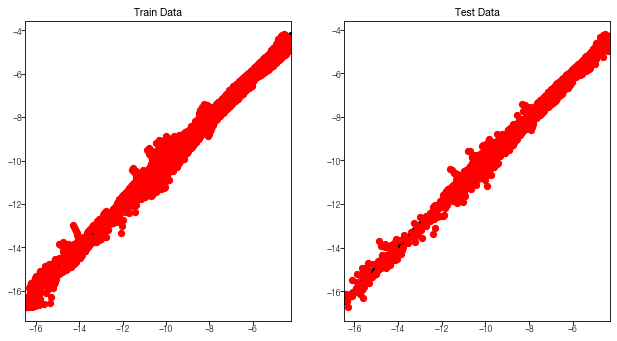

In [33]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

y_pred_norm_test = model.forward(x=dataset['test_input']).detach().cpu().numpy()
y_pred_norm_train = model.forward(x=dataset['train_input']).detach().cpu().numpy()

y_pred_test = scaler_y.inverse_transform(y_pred_norm_test)
y_pred_train = scaler_y.inverse_transform(y_pred_norm_train)

r2_score = {
    "train": r2_score(y_train, y_pred_train),
    "test": r2_score(y_test, y_pred_test),
}
print(r2_score)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax_train = ax[0]
ax_train.scatter(y_train, y_train, color='k')
ax_train.scatter(y_train, y_pred_train, color='r')
ax_train.set_title("Train Data")

ax_test = ax[1]
ax_test.scatter(y_test, y_test, color='k')
ax_test.scatter(y_test, y_pred_test, color='r')
ax_test.set_title("Test Data")

plt.savefig(save_heading + "_symbolic_eval.png")
plt.show()

In [34]:
torch.save(model.state_dict(), f"{save_heading}_model.pt")

In [35]:
import pickle

with open(save_heading + 'my_scaler_X.pkl', 'wb') as f:
    pickle.dump(scaler_X, f)

with open(save_heading + 'my_scaler_y.pkl', 'wb') as f:
    pickle.dump(scaler_y, f)

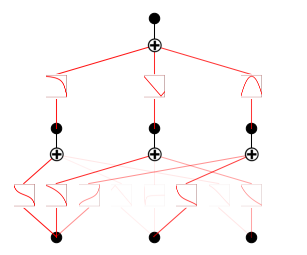

In [36]:
model.plot()